<a href="https://colab.research.google.com/github/ayush-99/Smoke-Fire_CNN/blob/main/Smoke_fire_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the 2nd notebook as I already had many models on the main and I wanted to keep it clean.
This notebook just shows me trying to implement MobileNetV2 instead of VGG16 to tacke the overfitting problem as it is a simpler network

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from glob import glob

In [ ]:
train_path = '/content/drive/My Drive/dataset/train'
val_path = '/content/drive/My Drive/dataset/test'

In [ ]:
folders = glob('/content/drive/My Drive/dataset/train/*')
print('Number of classes:', len(folders), '\nThese classes are: ', os.listdir(train_path))

Number of classes: 3 
These classes are:  ['default', 'fire', 'smoke']


In [ ]:
print('Number of images in fire class: ', len(os.listdir(train_path+"/fire")))
print('Number of images in smoke class: ', len(os.listdir(train_path+"/smoke")))
print('Number of images in default class: ', len(os.listdir(train_path+"/default")))

Number of images in fire class:  715
Number of images in smoke class:  793
Number of images in default class:  534


In [ ]:
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
image_size = [224,224,3]

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
                              )

In [ ]:
train_batches = image_gen.flow_from_directory(directory = train_path, target_size=(224,224), batch_size = 16)
val_batches = image_gen.flow_from_directory(directory = val_path, target_size=(224,224), batch_size = 16)

Found 2042 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
for image_batch, labels_batch in train_batches:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16, 3)


In [ ]:
base_model = MobileNetV2(input_shape=image_size, weights = 'imagenet', include_top= False, classes = len(folders))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [ ]:
x = Flatten()(base_model.output)
fc1 = Dense(4096, activation = 'relu')(x)
fc2 = Dense(4096, activation = 'relu')(fc1)
prediction = Dense(len(folders), activation = 'softmax')(fc2)
model = Model(inputs = base_model.input, outputs = prediction)

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

In [ ]:
tr  = model.fit_generator(train_batches, epochs = 25, validation_data=val_batches, steps_per_epoch= len(train_batches), validation_steps= len(val_batches) )

Epoch 1/25
128/128 [==============================] - 52s 408ms/step - loss: 6.8190 - accuracy: 0.3673 - val_loss: 1.0923 - val_accuracy: 0.3959
Epoch 2/25
128/128 [==============================] - 52s 403ms/step - loss: 1.1410 - accuracy: 0.3712 - val_loss: 1.0863 - val_accuracy: 0.3578
Epoch 3/25
128/128 [==============================] - 51s 402ms/step - loss: 1.1093 - accuracy: 0.3883 - val_loss: 1.0852 - val_accuracy: 0.3578
Epoch 4/25
128/128 [==============================] - 51s 397ms/step - loss: 1.1153 - accuracy: 0.3844 - val_loss: 1.0819 - val_accuracy: 0.3578
Epoch 5/25
128/128 [==============================] - 51s 397ms/step - loss: 1.0923 - accuracy: 0.3663 - val_loss: 1.0848 - val_accuracy: 0.3578
Epoch 6/25
128/128 [==============================] - 51s 398ms/step - loss: 1.1168 - accuracy: 0.3883 - val_loss: 1.0854 - val_accuracy: 0.3578
Epoch 7/25
128/128 [==============================] - 51s 399ms/step - loss: 1.0982 - accuracy: 0.3869 - val_loss: 1.0826 - val_ac

KeyboardInterrupt: ignored

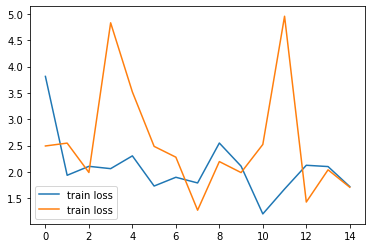

In [ ]:
plt.plot(tr.history['loss'], label = 'train loss')
plt.plot(tr.history['val_loss'], label = 'train loss')
plt.legend()
plt.show()

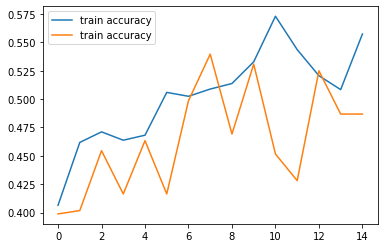

In [ ]:
plt.plot(tr.history['accuracy'], label = 'train accuracy')
plt.plot(tr.history['val_accuracy'], label = 'train accuracy')
plt.legend()
plt.show()